#Leg Circumduction Analysis

The purpose of this notebook is to perform the analysis to determine if leg circumduction is reduced with either the PPAFO or the AFO compared with the participant's own shoes

In [1]:
%matplotlib inline
%precision 3

import numpy as np
import ReadCsvs as rc
import thinkstats2
import thinkplot
import JointAngFuncs as jaf
import math

In [2]:
AFO, PPAFO, Shoes=rc.ReadGaitData()

Sub001_6MW_AFO_0001.mat
Sub001_6MW_AFO_0002.mat
Sub001_6MW_AFO_0003.mat
Sub001_6MW_AFO_0004.mat
Sub001_6MW_AFO_0005.mat
Sub001_6MW_AFO_0006.mat
Sub001_6MW_AFO_0007.mat
Sub001_6MW_AFO_0008.mat
Sub001_6MW_AFO_0009.mat
Sub001_6MW_PPAFO_0001.mat
Sub001_6MW_PPAFO_0002.mat
Sub001_6MW_PPAFO_0003.mat
Sub001_6MW_PPAFO_0004.mat
Sub001_6MW_PPAFO_0005.mat
Sub001_6MW_PPAFO_0006.mat
Sub001_6MW_PPAFO_0007.mat
Sub001_6MW_PPAFO_0008.mat
Sub001_6MW_PPAFO_0009.mat
Sub001_6MW_Shoes_0001.mat
Sub001_6MW_Shoes_0002.mat
Sub001_6MW_Shoes_0003.mat
Sub001_6MW_Shoes_0004.mat
Sub001_6MW_Shoes_0005.mat
Sub001_6MW_Shoes_0006.mat
Sub001_6MW_Shoes_0007.mat
Sub001_6MW_Shoes_0008.mat
Sub001_6MW_Shoes_0009.mat
Sub002_6MW_AFO_0001.mat
Sub002_6MW_AFO_0002.mat
Sub002_6MW_AFO_0003.mat
Sub002_6MW_AFO_0004.mat
Sub002_6MW_AFO_0005.mat
Sub002_6MW_AFO_0006.mat
Sub002_6MW_AFO_0007.mat
Sub002_6MW_AFO_0008.mat
Sub002_6MW_AFO_0009.mat
Sub002_6MW_PPAFO_0001.mat
Sub002_6MW_PPAFO_0002.mat
Sub002_6MW_PPAFO_0003.mat
Sub002_6MW_PPAFO_0004.

###Step 1: Compute the relevant joint angles

The markers we will use to compute leg circumduction will be the two ASIS markers as well as the THIGH markers. We start by doing a quick visualization to get a sense of what to expect.

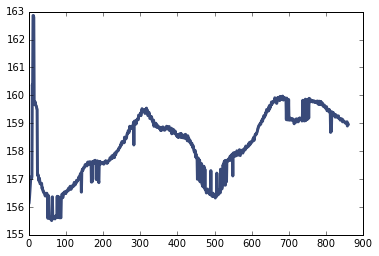

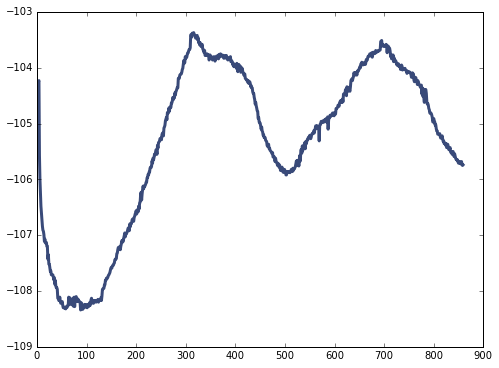

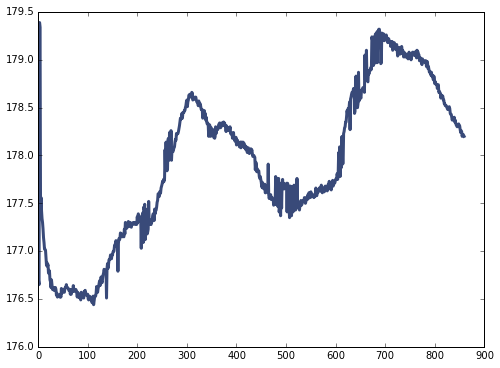

In [3]:
data=AFO[1].GetTrial(1).GetData('y')

thinkplot.Plot(data['R_ASIS'])
thinkplot.Show(legend=False)

thinkplot.Plot(data['L_ASIS'])
thinkplot.Show(legend=False)

thinkplot.Plot(data['R_THIGH'])
thinkplot.Show(legend=False)

 To start, we're going to assume that leg circumduction can be quantified just by how much the leg swings out to the side as the participant walks. For that, we can compute the joint angle observed by looking in the Y-Z plane

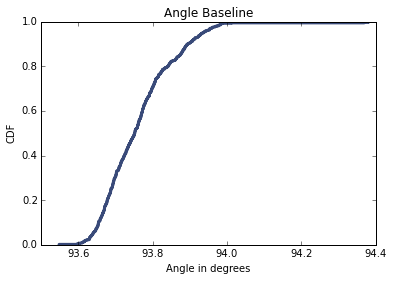

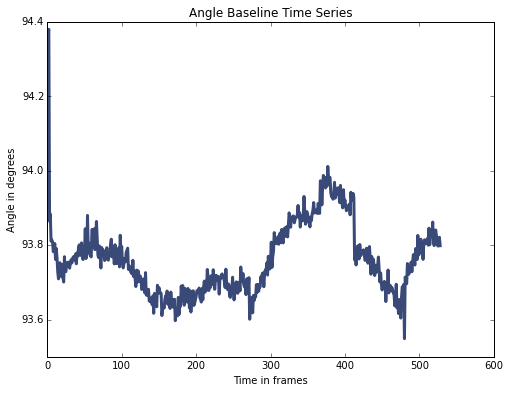

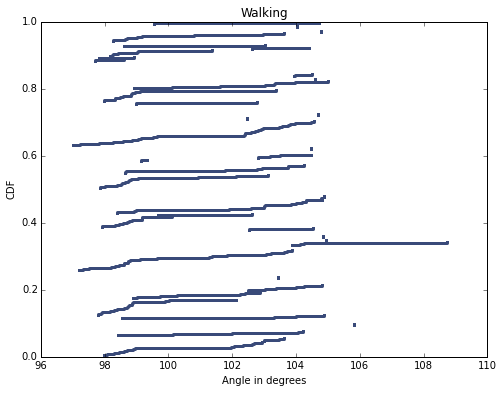

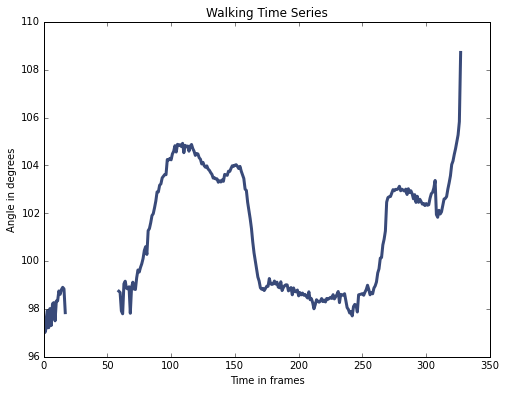

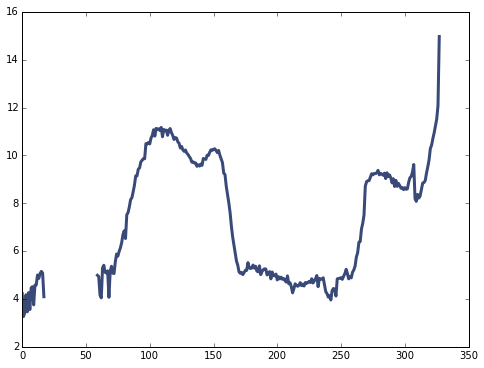

In [4]:
angles=jaf.JointAngles(AFO, PPAFO, Shoes, 'Shoes', 1, 1, 'R_ASIS', 'L_ASIS','R_THIGH' )
#print angles
#thinkplot.Plot(angles[0], angles[1])

angle_diff=jaf.AngleDiff(AFO, PPAFO, Shoes, 'Shoes', 1, 1, 5, 'R_ASIS', 'L_ASIS','R_THIGH', True, False)

thinkplot.Plot(angle_diff)
thinkplot.Show(legend=False)